In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import scipy.stats as stats
import statsmodels.stats.api as sms

from IPython.display import display
from IPython.display import Markdown as md
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 4)

import warnings
warnings.filterwarnings('ignore')

def dp(df, r = 5, c = None):
    from IPython.display import display
    with pd.option_context('display.max_rows', 4, 'display.max_columns', None):
        display(df)

def fg(w = 6, h = 4, dpi = 120):
    plt.rcParams['figure.figsize'] = (w,h)
    plt.rcParams['figure.dpi'] = dpi
fg()

In [2]:
df = pd.read_csv('data/dados_tratados.csv')

In [3]:
df.shape

(136, 10)

In [4]:
df.head()

,Analg.e9.sicos,Dor_costas,Dor_pernas,Masc,D29,D30,Tempo com a dor nas costas,Intensidade da dor nas pernas,Intensidade da dor no momento,SF12_M1_4_v1
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.756492,-0.821817,1.194782
1,1.0,1.0,0.0,1.0,0.0,0.0,3.0,-0.756492,-0.821817,1.194782
...,...,...,...,...,...,...,...,...,...,...
3,1.0,1.0,0.0,1.0,1.0,1.0,4.0,-0.756492,0.966457,-0.943249
4,1.0,1.0,0.0,0.0,0.0,0.0,4.0,-0.756492,0.966457,0.482105


In [5]:
X = df.drop('D30', axis = 1)

In [6]:
y = df['D30']

In [7]:
y.shape

(136,)

# @ Separação treino e teste

In [8]:
# Modulo de separacao de dados de treino e dados de teste
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3)

In [9]:
y_test.shape

(41,)

# % Regressão Logistica

## Modelo

In [10]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train,y_train)

LogisticRegression()

### Previsoes

In [11]:
THRESHOLD = 0.45
previsoes = np.where(lr.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

### Métricas

In [12]:
from sklearn.metrics import confusion_matrix, accuracy_score

acuracia = np.round(accuracy_score(y_test, previsoes),2);
matriz = confusion_matrix(y_test, previsoes);

In [13]:
y_test.values.reshape(-1,1).shape

(41, 1)

In [14]:
X_test.shape

(41, 9)

In [15]:
class ml():
    
    '''classe para pipeline de ml'''
    def __init__(self, X, y, model, modelname, threshold = 0.5):
        self.y = y
        self.X = X
        self.model = model
        self.modelname = modelname
        self.threshold = threshold
        # A partir das funcoes
        self.X_train, self.X_test, self.y_train, self.y_test = self.split()
        
    def split(self, test_size = 0.3):
        '''Divisao treino e teste'''
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(self.X,
                                                            self.y,
                                                            test_size = test_size)
        
        return X_train, X_test, y_train, y_test
        
    def probs(self):
        '''Predict proba'''
        return self.model.predict_proba(self.X_test)[:,1]
    
    def pred(self):
        import numpy as np
        return np.where(self.probs() > self.threshold, 1, 0)

    def matriz(self):
        from confusionmatrix import matriz_confusao as cm
        cm = cm(self.y_test, self.pred())
        return cm

    def roccurve(self):
        '''Curva roc'''
        from sklearn.metrics import roc_curve
        import matplotlib.pyplot as plt
        # Gerar os dados da diagonal (no skill classifier)
        
        ns_probs = [0 for item in range(len(self.y_test))]
        ns_fpr, ns_tpr, ns_thres = roc_curve(self.y_test, ns_probs)

        #Probabilidades da classe positiva
        fpr, tpr, thresholds = roc_curve(self.y_test, self.probs())
        
        plt.plot(fpr, tpr, marker = '.', label = self.modelname)
        plt.plot(ns_fpr, ns_tpr, linestyle = '--', label = 'Classificador base')
        plt.xlabel('Razão de Falsos Positivos')
        plt.ylabel('Razão de Verdadeiros Positivos')
        plt.title('ROC Curve')
        plt.legend()
        plt.show()

    def precisionrecall(self):
        '''Precision Recall Curve'''
        import matplotlib.pyplot as plt
        from sklearn.metrics import precision_recall_curve

        precision, recall, thresholds = precision_recall_curve(self.y_test, self.probs())
        no_skill = len(self.y_test[self.y_test ==1]) / len(self.y_test)

        plt.plot([0,1], [no_skill, no_skill], linestyle = '--', label = 'Classificador base')
        plt.plot(precision, recall, marker = '.', label =  self.modelname)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend()
        plt.show()
    
    def auc(self):
        import numpy as np
        '''AUC'''
        from sklearn.metrics import roc_auc_score
        return np.round(roc_auc_score(self.y_test, self.probs()),2)
    
    def gini(self):
        '''GINI'''
        return 2*self.auc() - 1

    def cvresults(self, cv = 10):
        '''Metricas gerais: 
        - acuracia
        - f1
        - recall
        - precision'''
        from sklearn.model_selection import cross_validate
        res = cross_validate(self.model, self.X, self.y, cv = cv, 
                                  scoring = ['accuracy','f1','recall','precision'],
                                  return_train_score = True)

        f1 = res['test_f1'].mean()
        precision = res['test_precision'].mean()
        recall = res['test_recall'].mean()
        acuracia = res['test_accuracy'].mean()

        cvresults = pd.DataFrame({'acuracia':[acuracia],
                                  'precisao':[precision],
                                  'recall':[recall],
                                  'f1':[f1]})

        return cvresults
    
    

In [16]:
ml = ml(X,y,lr,'Regressão Logística')

In [17]:
from sklearn.metrics import confusion_matrix

Matriz de confusão:


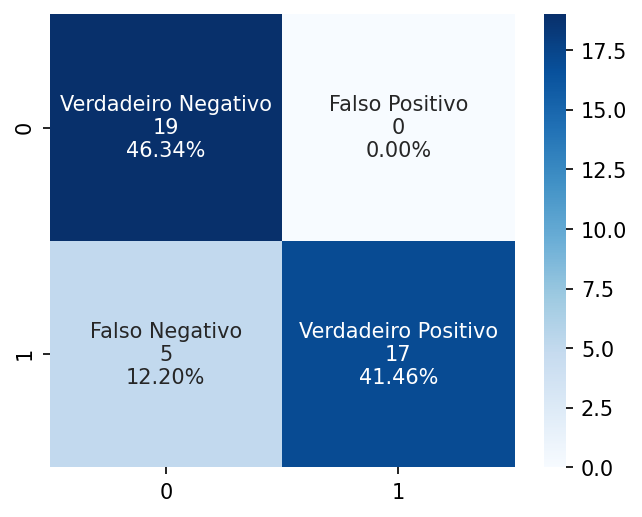

In [18]:
ml.matriz()

In [19]:
ml.auc()

0.96

In [20]:
ml.gini()

0.9199999999999999

In [21]:
ml.cvresults()

,acuracia,precisao,recall,f1
0,0.794505,0.815238,0.747619,0.753815


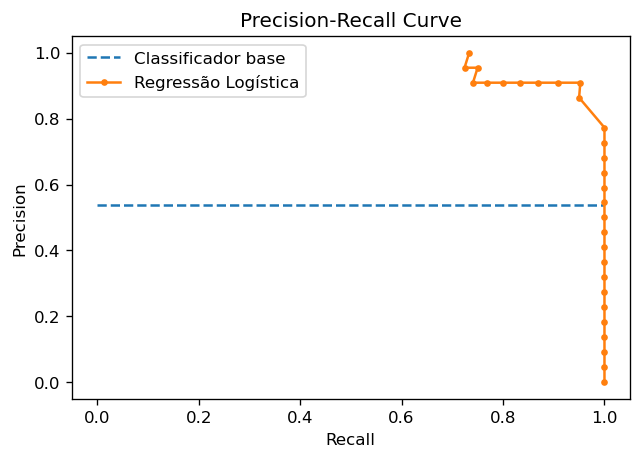

In [22]:
ml.precisionrecall()

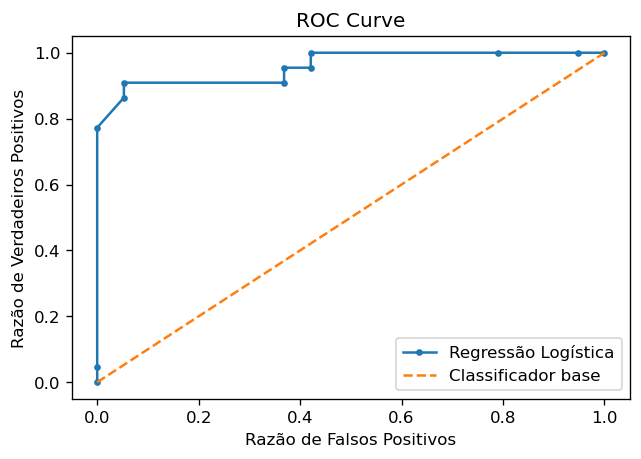

In [23]:
ml.roccurve()